# Import Required Library

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import TruncatedNormal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN
from keras.models import load_model

# Load data from Dataset

In [ ]:
data_train = pd.read_csv("/content/train_data.csv")
data_test = pd.read_csv("/content/test_data.csv")

In [ ]:
count_positive_ngly_train = data_train['Label'].value_counts()[1]
count_negative_ngly_train = data_train['Label'].value_counts()[0]

print(f"The number of positive N-Gly in Train dataset is: {count_positive_ngly_train}")
print(f"The number of negative N-Gly in Train dataset is: {count_negative_ngly_train}")

The number of positive N-Gly in Train dataset is: 1996
The number of negative N-Gly in Train dataset is: 18731


In [ ]:
count_positive_ngly_test = data_test['Label'].value_counts()[1]
count_negative_ngly_test = data_test['Label'].value_counts()[0]

print(f"The number of positive N-Gly in Train dataset is: {count_positive_ngly_test}")
print(f"The number of negative N-Gly in Train dataset is: {count_negative_ngly_test}")

The number of positive N-Gly in Train dataset is: 46
The number of negative N-Gly in Train dataset is: 179


In [ ]:
def filter_sequences(data_frame, sequence_column,
                     label_column, filter_chars=['B', 'J', 'O', 'U', 'X', 'Z']):
    # Filter sequences based on the specified characters
    filtered_data = data_frame[data_frame[sequence_column]
                               .apply(lambda seq: all(char not in seq for char in filter_chars))]

    # Reset index for the filtered DataFrame
    filtered_data.reset_index(drop=True, inplace=True)

    return filtered_data

# Define the irrelevant characters to be filtered
irrelevant_chars = ['B', 'J', 'O', 'U', 'X', 'Z']

# Apply the filter to the training data
data_train = filter_sequences(data_train, sequence_column='Seqence',
                              label_column='Label', filter_chars=irrelevant_chars)

In [ ]:
count_positive_ngly_train = data_train['Label'].value_counts()[1]
count_negative_ngly_train = data_train['Label'].value_counts()[0]

print(f"The number of positive N-Gly in Train dataset is: {count_positive_ngly_train}")
print(f"The number of negative N-Gly in Train dataset is: {count_negative_ngly_train}")

The number of positive N-Gly in Train dataset is: 1996
The number of negative N-Gly in Train dataset is: 18730


# One Hot Encoding and Train-Test Split

In [ ]:
desired_alphabet='ACDEFGHIKLMNPQRSTVWY'
encoder = OneHotEncoder(sparse_output=False, dtype=int, categories=[list(desired_alphabet)])

In [ ]:
train_sequences = data_train['Seqence']
train_labels = data_train['Label']

X_encoded = encoder.fit_transform([[char] for seq in train_sequences for char in seq])
X_encoded = X_encoded.reshape((len(train_sequences), len(train_sequences[0]), -1))

y = np.array(train_labels)

In [ ]:
test_sequences = data_test['Seqence']
test_labels = data_test['Label']

X_test_encoded = encoder.fit_transform([[char] for seq in test_sequences for char in seq])
X_test_encoded = X_test_encoded.reshape((len(test_sequences), len(test_sequences[0]), -1))

y_test = np.array(test_labels)

In [ ]:
X_train, X_val, y_train, y_val =
    train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#Convert the X_train shape to 2D so that it can be consumed with the Resampling Algorithm
X_train_2d = X_train.reshape((X_train.shape[0], -1))

# Model Training

## Function for DL Models

In [ ]:
# Function for Model Training
def train(model_name, saved_model_name, X_train, y_train):
  model = Sequential(name=model_name)
  model.add(Conv1D(10, kernel_size=2, strides=1, activation='relu', input_shape=(25, 20), name='CONV1'))
  model.add(Conv1D(10, kernel_size=3, strides=1, activation='relu', name='CONV2'))
  model.add(Flatten())
  model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01),
                  kernel_initializer=TruncatedNormal(mean=0, stddev=0.01), name='FC1'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01),
                  kernel_initializer=TruncatedNormal(mean=0, stddev=0.01), name='OUTPUT'))
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  checkpoint = tf.keras.callbacks.ModelCheckpoint(saved_model_name, monitor='val_loss',
                                                  save_best_only = True, verbose=1, mode='auto', save_freq='epoch')
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  print("\n")
  history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                      callbacks=[early_stopping, checkpoint])

  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  return model

## Without Resampling

Model: "without-resampling"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv1D)              (None, 24, 10)            410       
                                                                 
 CONV2 (Conv1D)              (None, 22, 10)            310       
                                                                 
 flatten_2 (Flatten)         (None, 220)               0         
                                                                 
 FC1 (Dense)                 (None, 32)                7072      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 OUTPUT (Dense)              (None, 1)                 33        
                                                                 
Total params: 7825 (30.57 KB)
Trainable params: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


511/519 [============================>.] - ETA: 0s - loss: 0.1474 - accuracy: 0.9174 - precision_2: 0.7362 - recall_2: 0.2201
Epoch 2: val_loss improved from 0.18552 to 0.12836, saving model to without-resampling.h5
519/519 [==============================] - 3s 6ms/step - loss: 0.1473 - accuracy: 0.9176 - precision_2: 0.7391 - recall_2: 0.2235 - val_loss: 0.1284 - val_accuracy: 0.9332 - val_precision_2: 0.7259 - val_recall_2: 0.4912
Epoch 3/100
512/519 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9440 - precision_2: 0.7134 - recall_2: 0.7003
Epoch 3: val_loss did not improve from 0.12836
519/519 [==============================] - 3s 5ms/step - loss: 0.1284 - accuracy: 0.9438 - precision_2: 0.7113 - recall_2: 0.7019 - val_loss: 0.1338 - val_accuracy: 0.9057 - val_precision_2: 0.7222 - val_recall_2: 0.0326
Epoch 4/100
514/519 [============================>.] - ETA: 0s - loss: 0.1208 - accuracy: 0.9512 - precision_2: 0.7122 - recall_2: 0.8285
Epoch 4: val_loss i

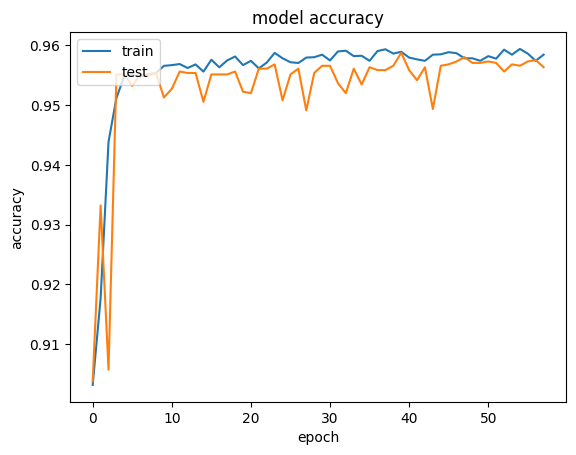

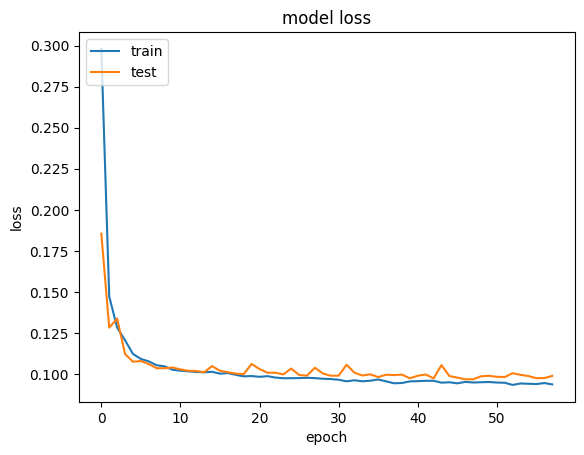

In [ ]:
model_woResampling = train(model_name="without-resampling", saved_model_name="without-resampling.h5",
      X_train=X_train, y_train=y_train)

In [ ]:
start_time = time.time()
y_pred_woResampling = model_woResampling.predict(X_test_encoded)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 4ms/step
Execution time on the test set: 0.3872 seconds


In [ ]:
start_time = time.time()
y_pred_woResampling = model_woResampling.predict(X_test_encoded)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 2ms/step
Execution time on the test set: 0.1174 seconds


In [ ]:
y_pred_binary_woResampling = np.round(y_pred_woResampling)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary_woResampling))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary_woResampling, digits=4))

Confusion Matrix:
[[169  10]
 [  3  43]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9826    0.9441    0.9630       179
           1     0.8113    0.9348    0.8687        46

    accuracy                         0.9422       225
   macro avg     0.8969    0.9395    0.9158       225
weighted avg     0.9475    0.9422    0.9437       225



In [ ]:
model_woResampling.evaluate(X_test_encoded, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.1471 - accuracy: 0.9422 - precision_2: 0.8113 - recall_2: 0.9348


[0.14714983105659485,
 0.9422222375869751,
 0.8113207817077637,
 0.9347826242446899]

## Denoised-Oversampling (Baseline)

In [ ]:
#Denoised (DELETE SEQUENCE CONTAINING X)

def filter_x_onsequences(data_frame, sequence_column, label_column, filter_char='X'):
    # Filter sequences based on the specified character
    filtered_data = data_frame[data_frame[sequence_column].apply(lambda seq: filter_char not in seq)]

    # Reset index for the filtered DataFrame
    filtered_data.reset_index(drop=True, inplace=True)

    return filtered_data

data_train_bl = filter_sequences(data_train, sequence_column='Seqence', label_column='Label', filter_char='X')

In [ ]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled_baseline, y_resampled_baseline = smote.fit_resample(X_train_2d, y_train)

print(f'Original train dataset shape: {Counter(y_train)}')
print(f'Resampled train dataset shape: {Counter(y_resampled_baseline)}')

Original train dataset shape: Counter({0: 14983, 1: 1597})
Resampled train dataset shape: Counter({0: 14983, 1: 14983})


In [ ]:
X_resampled_baseline = X_resampled_baseline.reshape((X_resampled_baseline.shape[0], len(train_sequences[0]), -1))

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv1D)              (None, 24, 10)            410       
                                                                 
 CONV2 (Conv1D)              (None, 22, 10)            310       
                                                                 
 flatten_3 (Flatten)         (None, 220)               0         
                                                                 
 FC1 (Dense)                 (None, 32)                7072      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 OUTPUT (Dense)              (None, 1)                 33        
                                                                 
Total params: 7825 (30.57 KB)
Trainable params: 7825 (30.5

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


934/937 [============================>.] - ETA: 0s - loss: 0.1114 - accuracy: 0.9695 - precision_3: 0.9689 - recall_3: 0.9701
Epoch 2: val_loss improved from 0.14352 to 0.14028, saving model to baseline.h5
937/937 [==============================] - 5s 5ms/step - loss: 0.1113 - accuracy: 0.9696 - precision_3: 0.9690 - recall_3: 0.9702 - val_loss: 0.1403 - val_accuracy: 0.9559 - val_precision_3: 0.6869 - val_recall_3: 0.9950
Epoch 3/100
932/937 [============================>.] - ETA: 0s - loss: 0.1020 - accuracy: 0.9704 - precision_3: 0.9676 - recall_3: 0.9734
Epoch 3: val_loss improved from 0.14028 to 0.12337, saving model to baseline.h5
937/937 [==============================] - 4s 5ms/step - loss: 0.1020 - accuracy: 0.9704 - precision_3: 0.9677 - recall_3: 0.9732 - val_loss: 0.1234 - val_accuracy: 0.9547 - val_precision_3: 0.7414 - val_recall_3: 0.8120
Epoch 4/100
925/937 [============================>.] - ETA: 0s - loss: 0.0938 - accuracy: 0.9712 - precision_3: 0.9673 - recall_3: 0.9

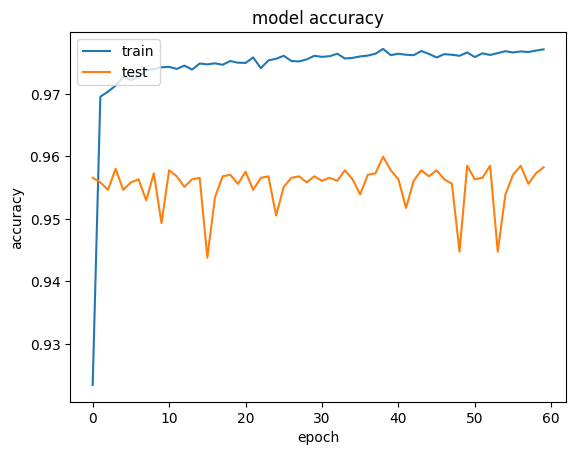

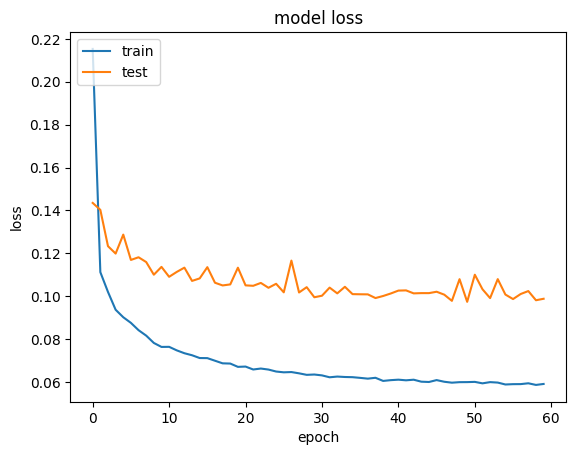

In [ ]:
model_baseline = train(model_name="baseline", saved_model_name="baseline.h5",
      X_train=X_resampled_baseline, y_train=y_resampled_baseline)

In [ ]:
start_time = time.time()
y_pred_baseline = model_baseline.predict(X_test_encoded)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 2ms/step
Execution time on the test set: 0.1194 seconds


In [ ]:
start_time = time.time()
y_pred_baseline = model_baseline.predict(X_test_encoded)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 2ms/step
Execution time on the test set: 0.1195 seconds


In [ ]:
y_pred_binary_baseline = np.round(y_pred_baseline)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary_baseline))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary_baseline, digits=4))

Confusion Matrix:
[[168  11]
 [  7  39]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9600    0.9385    0.9492       179
           1     0.7800    0.8478    0.8125        46

    accuracy                         0.9200       225
   macro avg     0.8700    0.8932    0.8808       225
weighted avg     0.9232    0.9200    0.9212       225



In [ ]:
model_baseline.evaluate(X_test_encoded, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.1497 - accuracy: 0.9200 - precision_3: 0.7800 - recall_3: 0.8478


[0.14967966079711914,
 0.9200000166893005,
 0.7799999713897705,
 0.8478260636329651]

## SMOTE-ENN

In [ ]:
# # Use this to check Optimum ENN Neighbours
# def CheckOptimumENN():
#   smote = SMOTE(sampling_strategy='minority', random_state=42)
#   X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train_2d, y_train)

#   for n_neighbors_value in range(1, 10):
#     enn = EditedNearestNeighbours(sampling_strategy='all', n_neighbors=n_neighbors_value)
#     X_resampled_combined, y_resampled_combined = enn.fit_resample(X_resampled_smote, y_resampled_smote)

#     print(f"n_neighbors = {n_neighbors_value}")
#     print(f"Resampled train dataset shape: {Counter(y_resampled_combined)}")
#     print("-----------------------------")

In [ ]:
#CheckOptimumENN()

In [ ]:
sme = SMOTEENN(smote=SMOTE(sampling_strategy='minority', random_state=42), enn=EditedNearestNeighbours(sampling_strategy='all', n_neighbors=2))
X_resampled_sme, y_resampled_sme = sme.fit_resample(X_train_2d, y_train)

print(f'Original train dataset shape: {Counter(y_train)}')
print(f'Resampled train dataset shape: {Counter(y_resampled_sme)}')

Original train dataset shape: Counter({0: 14983, 1: 1597})
Resampled train dataset shape: Counter({1: 14982, 0: 458})


In [ ]:
X_resampled_sme = X_resampled_sme.reshape((X_resampled_sme.shape[0], len(train_sequences[0]), -1))

Model: "smote-enn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv1D)              (None, 24, 10)            410       
                                                                 
 CONV2 (Conv1D)              (None, 22, 10)            310       
                                                                 
 flatten_6 (Flatten)         (None, 220)               0         
                                                                 
 FC1 (Dense)                 (None, 32)                7072      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 OUTPUT (Dense)              (None, 1)                 33        
                                                                 
Total params: 7825 (30.57 KB)
Trainable params: 7825 (30.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


481/483 [============================>.] - ETA: 0s - loss: 0.0671 - accuracy: 0.9703 - precision_6: 0.9703 - recall_6: 1.0000
Epoch 2: val_loss improved from 2.18397 to 1.05615, saving model to smote-enn.h5
483/483 [==============================] - 2s 5ms/step - loss: 0.0670 - accuracy: 0.9703 - precision_6: 0.9703 - recall_6: 1.0000 - val_loss: 1.0562 - val_accuracy: 0.0962 - val_precision_6: 0.0962 - val_recall_6: 1.0000
Epoch 3/100
475/483 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9798 - precision_6: 0.9796 - recall_6: 1.0000
Epoch 3: val_loss did not improve from 1.05615
483/483 [==============================] - 2s 5ms/step - loss: 0.0535 - accuracy: 0.9799 - precision_6: 0.9797 - recall_6: 1.0000 - val_loss: 1.2521 - val_accuracy: 0.2188 - val_precision_6: 0.1097 - val_recall_6: 1.0000
Epoch 4/100
477/483 [============================>.] - ETA: 0s - loss: 0.0464 - accuracy: 0.9896 - precision_6: 0.9894 - recall_6: 1.0000
Epoch 4: val_loss did not im

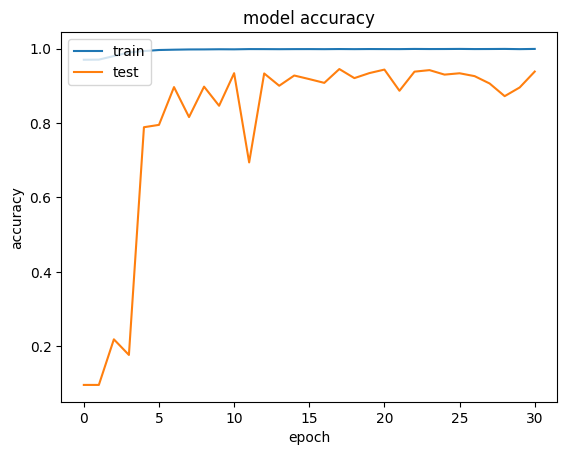

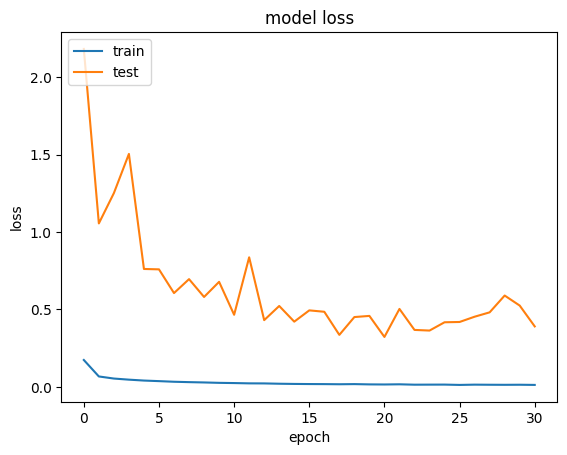

In [ ]:
model_sme = train(model_name="smote-enn", saved_model_name="smote-enn.h5",
      X_train=X_resampled_sme, y_train=y_resampled_sme)

In [ ]:
start_time = time.time()
y_pred_sme = model_sme.predict(X_test_encoded)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 2ms/step
Execution time on the test set: 0.1331 seconds


In [ ]:
start_time = time.time()
y_pred_sme = model_sme.predict(X_test_encoded)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 2ms/step
Execution time on the test set: 0.0839 seconds


In [ ]:
y_pred_binary_sme = np.round(y_pred_sme)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary_sme))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary_sme, digits=4))

Confusion Matrix:
[[167  12]
 [  0  46]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9330    0.9653       179
           1     0.7931    1.0000    0.8846        46

    accuracy                         0.9467       225
   macro avg     0.8966    0.9665    0.9250       225
weighted avg     0.9577    0.9467    0.9488       225



In [ ]:
model_sme.evaluate(X_test_encoded, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.4719 - accuracy: 0.9467 - precision_6: 0.7931 - recall_6: 1.0000


[0.47190186381340027, 0.9466666579246521, 0.7931034564971924, 1.0]

## SMOTE-TOMEK

In [ ]:
smtk = SMOTETomek(smote=SMOTE(sampling_strategy='minority', random_state=42), tomek=TomekLinks(sampling_strategy='all'))
X_resampled_smtk, y_resampled_smtk = smtk.fit_resample(X_train_2d, y_train)

print(f'Original train dataset shape: {Counter(y_train)}')
print(f'Resampled train dataset shape: {Counter(y_resampled_smtk)}')

Original train dataset shape: Counter({0: 14983, 1: 1597})
Resampled train dataset shape: Counter({0: 14983, 1: 14983})


In [ ]:
X_resampled_smtk = X_resampled_smtk.reshape((X_resampled_smtk.shape[0], len(train_sequences[0]), -1))

Model: "smote-tomek"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv1D)              (None, 24, 10)            410       
                                                                 
 CONV2 (Conv1D)              (None, 22, 10)            310       
                                                                 
 flatten_7 (Flatten)         (None, 220)               0         
                                                                 
 FC1 (Dense)                 (None, 32)                7072      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 OUTPUT (Dense)              (None, 1)                 33        
                                                                 
Total params: 7825 (30.57 KB)
Trainable params: 7825 (3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


937/937 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9702 - precision_7: 0.9687 - recall_7: 0.9718
Epoch 2: val_loss did not improve from 0.15706
937/937 [==============================] - 5s 5ms/step - loss: 0.1084 - accuracy: 0.9702 - precision_7: 0.9687 - recall_7: 0.9718 - val_loss: 0.1719 - val_accuracy: 0.9100 - val_precision_7: 0.7600 - val_recall_7: 0.0952
Epoch 3/100
937/937 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9703 - precision_7: 0.9680 - recall_7: 0.9728
Epoch 3: val_loss improved from 0.15706 to 0.13024, saving model to smote-tomek.h5
937/937 [==============================] - 4s 5ms/step - loss: 0.0998 - accuracy: 0.9703 - precision_7: 0.9680 - recall_7: 0.9728 - val_loss: 0.1302 - val_accuracy: 0.9448 - val_precision_7: 0.7415 - val_recall_7: 0.6541
Epoch 4/100
927/937 [============================>.] - ETA: 0s - loss: 0.0945 - accuracy: 0.9717 - precision_7: 0.9670 - recall_7: 0.9767
Epoch 4: val_loss improved

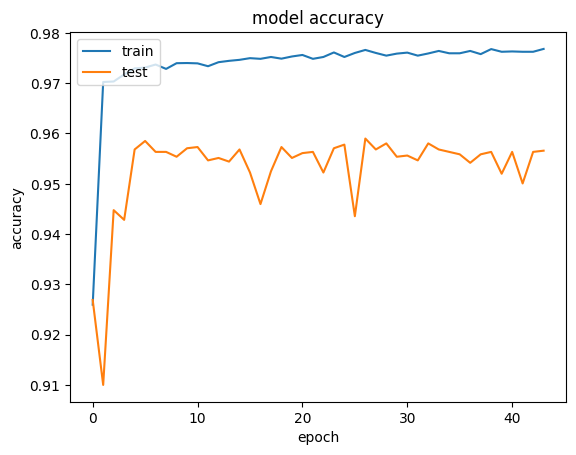

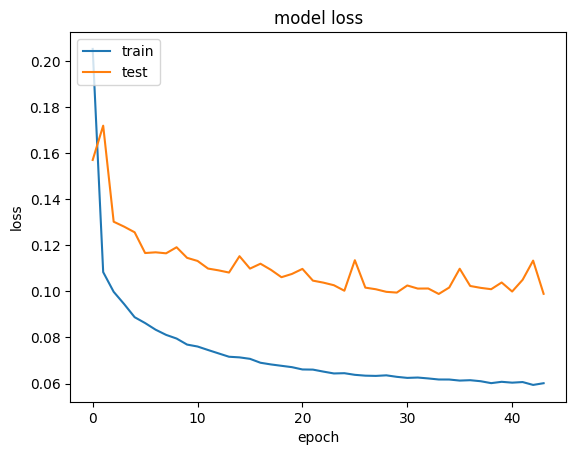

In [ ]:
model_smtk = train(model_name="smote-tomek", saved_model_name="smote-tomek.h5",
      X_train=X_resampled_smtk, y_train=y_resampled_smtk)

In [ ]:
start_time = time.time()
y_pred_smtk = model_smtk.predict(X_test_encoded)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 2ms/step
Execution time on the test set: 0.1713 seconds


In [ ]:
start_time = time.time()
y_pred_smtk = model_smtk.predict(X_test_encoded)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 4ms/step
Execution time on the test set: 0.3374 seconds


In [ ]:
y_pred_binary_smtk = np.round(y_pred_smtk)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary_smtk))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary_smtk, digits=4))

Confusion Matrix:
[[168  11]
 [  1  45]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9941    0.9385    0.9655       179
           1     0.8036    0.9783    0.8824        46

    accuracy                         0.9467       225
   macro avg     0.8988    0.9584    0.9239       225
weighted avg     0.9551    0.9467    0.9485       225



In [ ]:
model_smtk.evaluate(X_test_encoded, y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.1482 - accuracy: 0.9333 - precision_3: 0.8039 - recall_3: 0.8913


[0.1482434719800949,
 0.9333333373069763,
 0.8039215803146362,
 0.8913043737411499]

## ADASYN

In [ ]:
X_resampled_adasyn, y_resampled_adasyn = ADASYN(sampling_strategy='auto', random_state=42).fit_resample(X_train_2d, y_train)

print(f'Original train dataset shape: {Counter(y_train)}')
print(f'Resampled train dataset shape: {Counter(y_resampled_adasyn)}')

Original train dataset shape: Counter({0: 14983, 1: 1597})
Resampled train dataset shape: Counter({1: 15026, 0: 14983})


In [ ]:
X_resampled_adasyn = X_resampled_adasyn.reshape((X_resampled_adasyn.shape[0], len(train_sequences[0]), -1))

Model: "adasyn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv1D)              (None, 24, 10)            410       
                                                                 
 CONV2 (Conv1D)              (None, 22, 10)            310       
                                                                 
 flatten_8 (Flatten)         (None, 220)               0         
                                                                 
 FC1 (Dense)                 (None, 32)                7072      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 OUTPUT (Dense)              (None, 1)                 33        
                                                                 
Total params: 7825 (30.57 KB)
Trainable params: 7825 (30.57 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


932/938 [============================>.] - ETA: 0s - loss: 0.1061 - accuracy: 0.9703 - precision_8: 0.9686 - recall_8: 0.9722
Epoch 2: val_loss improved from 0.18529 to 0.13445, saving model to adasyn.h5
938/938 [==============================] - 4s 5ms/step - loss: 0.1060 - accuracy: 0.9703 - precision_8: 0.9685 - recall_8: 0.9724 - val_loss: 0.1344 - val_accuracy: 0.9450 - val_precision_8: 0.7408 - val_recall_8: 0.6591
Epoch 3/100
931/938 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.9711 - precision_8: 0.9666 - recall_8: 0.9759
Epoch 3: val_loss improved from 0.13445 to 0.12505, saving model to adasyn.h5
938/938 [==============================] - 4s 5ms/step - loss: 0.0982 - accuracy: 0.9710 - precision_8: 0.9669 - recall_8: 0.9756 - val_loss: 0.1251 - val_accuracy: 0.9515 - val_precision_8: 0.7281 - val_recall_8: 0.7920
Epoch 4/100
937/938 [============================>.] - ETA: 0s - loss: 0.0902 - accuracy: 0.9720 - precision_8: 0.9663 - recall_8: 0.9783


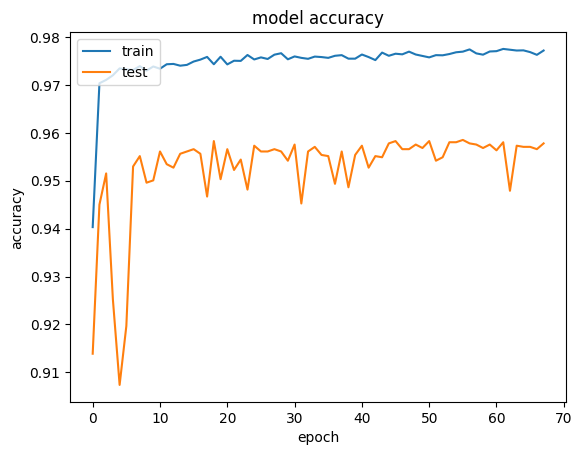

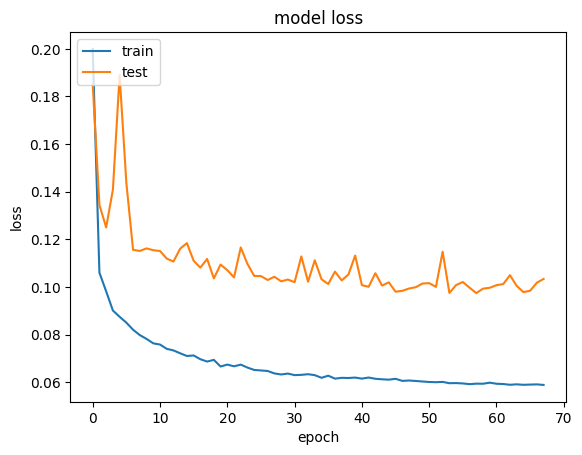

In [ ]:
model_adasyn = train(model_name="adasyn", saved_model_name="adasyn.h5",
      X_train=X_resampled_adasyn, y_train=y_resampled_adasyn)

In [ ]:
start_time = time.time()
y_pred_adasyn = model_adasyn.predict(X_test_encoded)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 3ms/step
Execution time on the test set: 0.1245 seconds


In [ ]:
y_pred_binary_adasyn = np.round(y_pred_adasyn)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary_adasyn))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary_adasyn, digits=4))

Confusion Matrix:
[[167  12]
 [  1  45]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9940    0.9330    0.9625       179
           1     0.7895    0.9783    0.8738        46

    accuracy                         0.9422       225
   macro avg     0.8918    0.9556    0.9182       225
weighted avg     0.9522    0.9422    0.9444       225



In [ ]:
model_adasyn.evaluate(X_test_encoded, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.1353 - accuracy: 0.9422 - precision_8: 0.7895 - recall_8: 0.9783


[0.13529829680919647, 0.9422222375869751, 0.7894737124443054, 0.97826087474823]

## Random Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
X_resampled_ros, y_resampled_ros = RandomOverSampler(sampling_strategy='minority', random_state=42).fit_resample(X_train_2d, y_train)

print(f'Original train dataset shape: {Counter(y_train)}')
print(f'Resampled train dataset shape: {Counter(y_resampled_ros)}')

Original train dataset shape: Counter({0: 14983, 1: 1597})
Resampled train dataset shape: Counter({0: 14983, 1: 14983})


In [ ]:
X_resampled_ros = X_resampled_ros.reshape((X_resampled_ros.shape[0], len(train_sequences[0]), -1))

Model: "random-oversampling"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv1D)              (None, 24, 10)            410       
                                                                 
 CONV2 (Conv1D)              (None, 22, 10)            310       
                                                                 
 flatten_15 (Flatten)        (None, 220)               0         
                                                                 
 FC1 (Dense)                 (None, 32)                7072      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 OUTPUT (Dense)              (None, 1)                 33        
                                                                 
Total params: 7825 (30.57 KB)
Trainable params:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


933/937 [============================>.] - ETA: 0s - loss: 0.1513 - accuracy: 0.9706 - precision_15: 0.9483 - recall_15: 0.9954
Epoch 2: val_loss improved from 0.20795 to 0.18120, saving model to random_oversampling.h5
937/937 [==============================] - 5s 5ms/step - loss: 0.1512 - accuracy: 0.9706 - precision_15: 0.9484 - recall_15: 0.9954 - val_loss: 0.1812 - val_accuracy: 0.9537 - val_precision_15: 0.6757 - val_recall_15: 0.9975
Epoch 3/100
932/937 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.9723 - precision_15: 0.9511 - recall_15: 0.9957
Epoch 3: val_loss improved from 0.18120 to 0.15330, saving model to random_oversampling.h5
937/937 [==============================] - 4s 5ms/step - loss: 0.1436 - accuracy: 0.9722 - precision_15: 0.9509 - recall_15: 0.9957 - val_loss: 0.1533 - val_accuracy: 0.9544 - val_precision_15: 0.6798 - val_recall_15: 0.9950
Epoch 4/100
930/937 [============================>.] - ETA: 0s - loss: 0.1392 - accuracy: 0.9726 - p

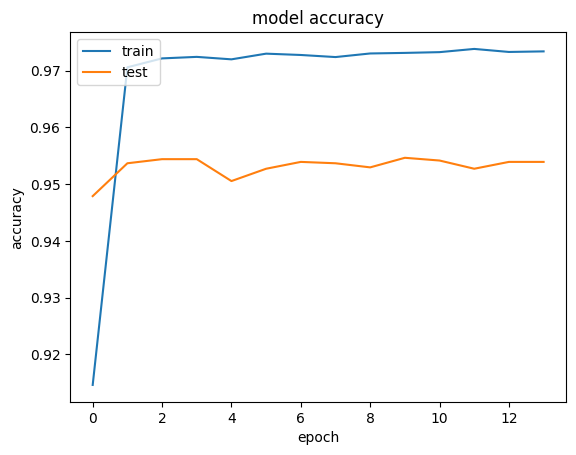

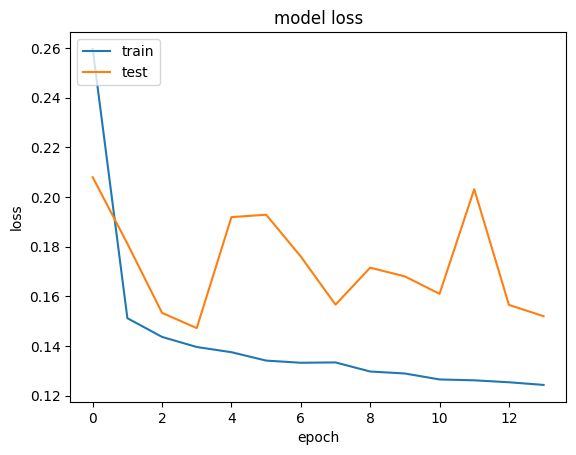

In [ ]:
model_ros = train(model_name="random-oversampling", saved_model_name="random_oversampling.h5",
      X_train=X_resampled_ros, y_train=y_resampled_ros)

In [ ]:
start_time = time.time()
y_pred_ros = model_ros.predict(X_test_encoded)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 3ms/step
Execution time on the test set: 0.2209 seconds


In [ ]:
y_pred_binary_ros = np.round(y_pred_ros)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary_ros))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary_ros, digits=4))

Confusion Matrix:
[[167  12]
 [  0  46]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9330    0.9653       179
           1     0.7931    1.0000    0.8846        46

    accuracy                         0.9467       225
   macro avg     0.8966    0.9665    0.9250       225
weighted avg     0.9577    0.9467    0.9488       225



In [ ]:
model_ros.evaluate(X_test_encoded, y_test)

8/8 [==============================] - 0s 5ms/step - loss: 0.1791 - accuracy: 0.9467 - precision_15: 0.7931 - recall_15: 1.0000


[0.1790708601474762, 0.9466666579246521, 0.7931034564971924, 1.0]

## Random Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
X_resampled_rus, y_resampled_rus = RandomUnderSampler(sampling_strategy='majority', random_state=42).fit_resample(X_train_2d, y_train)

print(f'Original train dataset shape: {Counter(y_train)}')
print(f'Resampled train dataset shape: {Counter(y_resampled_rus)}')

Original train dataset shape: Counter({0: 14983, 1: 1597})
Resampled train dataset shape: Counter({0: 1597, 1: 1597})


In [ ]:
X_resampled_rus = X_resampled_rus.reshape((X_resampled_rus.shape[0], len(train_sequences[0]), -1))

Model: "random-undersampling"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv1D)              (None, 24, 10)            410       
                                                                 
 CONV2 (Conv1D)              (None, 22, 10)            310       
                                                                 
 flatten_14 (Flatten)        (None, 220)               0         
                                                                 
 FC1 (Dense)                 (None, 32)                7072      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 OUTPUT (Dense)              (None, 1)                 33        
                                                                 
Total params: 7825 (30.57 KB)
Trainable params

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 90/100 [==========================>...] - ETA: 0s - loss: 0.5061 - accuracy: 0.8198 - precision_14: 0.7674 - recall_14: 0.9189
Epoch 2: val_loss improved from 0.68900 to 0.29339, saving model to random_undersampling.h5
100/100 [==============================] - 1s 7ms/step - loss: 0.4822 - accuracy: 0.8334 - precision_14: 0.7828 - recall_14: 0.9230 - val_loss: 0.2934 - val_accuracy: 0.9358 - val_precision_14: 0.6009 - val_recall_14: 0.9925
Epoch 3/100
 95/100 [===========================>..] - ETA: 0s - loss: 0.2158 - accuracy: 0.9638 - precision_14: 0.9420 - recall_14: 0.9889
Epoch 3: val_loss improved from 0.29339 to 0.22125, saving model to random_undersampling.h5
100/100 [==============================] - 1s 8ms/step - loss: 0.2138 - accuracy: 0.9643 - precision_14: 0.9422 - recall_14: 0.9894 - val_loss: 0.2212 - val_accuracy: 0.9421 - val_precision_14: 0.6248 - val_recall_14: 0.9975
Epoch 4/100
 94/100 [===========================>..] - ETA: 0s - loss: 0.1819 - accuracy: 0.9678 -

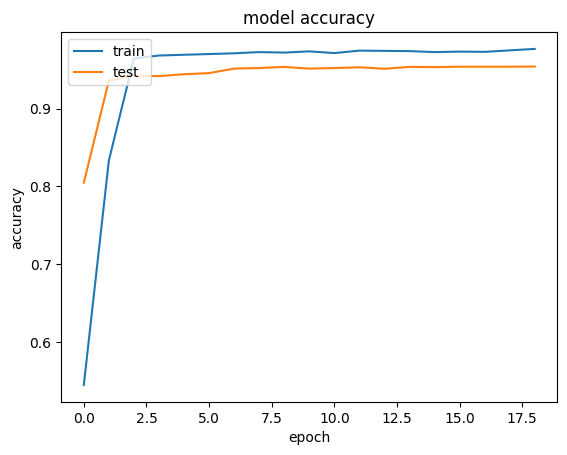

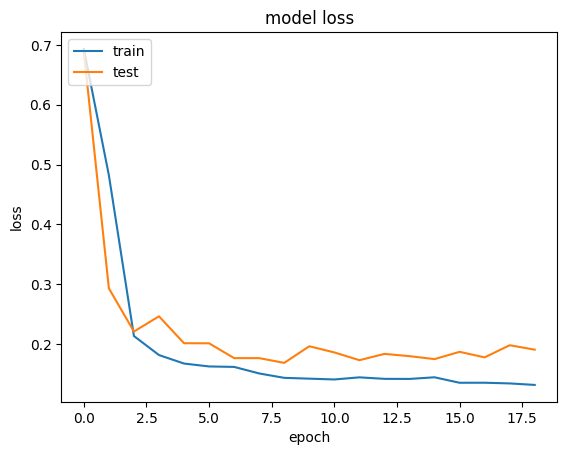

In [ ]:
model_rus = train(model_name="random-undersampling", saved_model_name="random_undersampling.h5",
      X_train=X_resampled_rus, y_train=y_resampled_rus)

In [ ]:
start_time = time.time()
y_pred_rus = model_rus.predict(X_test_encoded)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 2ms/step
Execution time on the test set: 0.1222 seconds


In [ ]:
y_pred_binary_rus = np.round(y_pred_rus)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary_rus))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary_rus, digits=4))

Confusion Matrix:
[[167  12]
 [  0  46]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9330    0.9653       179
           1     0.7931    1.0000    0.8846        46

    accuracy                         0.9467       225
   macro avg     0.8966    0.9665    0.9250       225
weighted avg     0.9577    0.9467    0.9488       225



In [ ]:
model_rus.evaluate(X_test_encoded, y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.2340 - accuracy: 0.9467 - precision_14: 0.7931 - recall_14: 1.0000


[0.23401343822479248, 0.9466666579246521, 0.7931034564971924, 1.0]

## ADASYN-ENN

In [ ]:
X_resampled_adasyn_enn, y_resampled_adasyn_enn = ADASYN(sampling_strategy='minority', random_state=42).fit_resample(X_train_2d, y_train)
X_resampled_adasyn_enn, y_resampled_adasyn_enn = EditedNearestNeighbours(sampling_strategy='all', n_neighbors=2).fit_resample(X_resampled_adasyn_enn, y_resampled_adasyn_enn)

print(f'Original train dataset shape: {Counter(y_train)}')
print(f'Resampled train dataset shape: {Counter(y_resampled_adasyn_enn)}')

Original train dataset shape: Counter({0: 14983, 1: 1597})
Resampled train dataset shape: Counter({1: 15025, 0: 456})


In [ ]:
X_resampled_adasyn_enn = X_resampled_adasyn_enn.reshape((X_resampled_adasyn_enn.shape[0], len(train_sequences[0]), -1))

In [ ]:
model_adasyn_enn = train(model_name="adasyn_enn", saved_model_name="adasyn_enn.h5",
      X_train=X_resampled_adasyn_enn, y_train=y_resampled_adasyn_enn)

Model: "adasyn_enn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv1D)              (None, 24, 10)            410       
                                                                 
 CONV2 (Conv1D)              (None, 22, 10)            310       
                                                                 
 flatten_5 (Flatten)         (None, 220)               0         
                                                                 
 FC1 (Dense)                 (None, 64)                14144     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 OUTPUT (Dense)              (None, 1)                 65        
                                                                 
Total params: 14929 (58.32 KB)
Trainable params: 14929 (

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


481/484 [============================>.] - ETA: 0s - loss: 0.0690 - accuracy: 0.9704 - precision_5: 0.9704 - recall_5: 1.0000
Epoch 2: val_loss improved from 1.43179 to 1.16755, saving model to adasyn_enn.h5
484/484 [==============================] - 3s 5ms/step - loss: 0.0689 - accuracy: 0.9705 - precision_5: 0.9705 - recall_5: 1.0000 - val_loss: 1.1676 - val_accuracy: 0.0962 - val_precision_5: 0.0962 - val_recall_5: 1.0000
Epoch 3/100
482/484 [============================>.] - ETA: 0s - loss: 0.0590 - accuracy: 0.9770 - precision_5: 0.9769 - recall_5: 1.0000
Epoch 3: val_loss improved from 1.16755 to 0.98540, saving model to adasyn_enn.h5
484/484 [==============================] - 2s 5ms/step - loss: 0.0589 - accuracy: 0.9771 - precision_5: 0.9770 - recall_5: 1.0000 - val_loss: 0.9854 - val_accuracy: 0.3208 - val_precision_5: 0.1241 - val_recall_5: 1.0000
Epoch 4/100
482/484 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9863 - precision_5: 0.9862 - recall_5:

In [ ]:
start_time = time.time()
y_pred_adasyn_enn = model_adasyn_enn.predict(X_test_encoded)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 2ms/step
Execution time on the test set: 0.1293 seconds


In [ ]:
y_pred_binary_adasyn_enn = np.round(y_pred_adasyn_enn)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary_adasyn_enn))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary_adasyn_enn, digits=4))

Confusion Matrix:
[[162  17]
 [  0  46]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9050    0.9501       179
           1     0.7302    1.0000    0.8440        46

    accuracy                         0.9244       225
   macro avg     0.8651    0.9525    0.8971       225
weighted avg     0.9448    0.9244    0.9285       225



In [ ]:
model_adasyn_enn.evaluate(X_test_encoded, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.4672 - accuracy: 0.9244 - precision_5: 0.7302 - recall_5: 1.0000


[0.46717405319213867, 0.9244444370269775, 0.7301587462425232, 1.0]

## Hyper Parameter Tuning using Grid Search

In [ ]:
# !pip install scikeras

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv1D, Flatten, Dense, Dropout
# from keras.initializers import TruncatedNormal
# from keras.regularizers import l2
# from sklearn.model_selection import GridSearchCV
# from keras.callbacks import EarlyStopping
# import tensorflow as tf
# from scikeras.wrappers import KerasClassifier

# # Function for Model Training
# def create_cnn_model(filters, kernel_size, dense_units, dropout_rate, epochs=100, batch_size=32):
#     model = Sequential()
#     model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=1, activation='relu', input_shape=(25, 20)))
#     model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=1, activation='relu'))
#     model.add(Flatten())
#     model.add(Dense(units=dense_units, activation='relu', kernel_regularizer=l2(0.01), kernel_initializer=TruncatedNormal(mean=0, stddev=0.01)))
#     model.add(Dropout(rate=dropout_rate))
#     model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.01), kernel_initializer=TruncatedNormal(mean=0, stddev=0.01)))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

#     return model

# # Set your X_train and y_train data here
# X_train, y_train = X_resampled_sme, y_resampled_sme

# # Define the hyperparameter grid
# filters = [10, 20]
# kernel_size = [2, 3]
# dropout_rate = [0.3, 0.5]
# dense_units = [32, 64]
# batch_size = [16, 32, 64]

# param_grid = dict(filters=filters, kernel_size=kernel_size, dropout_rate=dropout_rate,
#                   dense_units=dense_units, batch_size=batch_size)

# # Wrap the model using KerasClassifier
# model = KerasClassifier(build_fn=create_cnn_model, verbose=1)

# # Perform Grid Search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)
# grid_result = grid.fit(X_train, y_train)

# # Print Results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


## CNN-LSTM

In [ ]:
# from keras.layers import MaxPooling1D, LSTM

# # Function for Model Training
# def train_cnn_lstm(model_name, saved_model_name, X_train, y_train):
#   model = Sequential(name=model_name)
#   model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(25, 20), name='CONV1'))
#   model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', name='CONV2'))
#   model.add(Dropout(0.5))
#   model.add(MaxPooling1D(pool_size=2))
#   model.add(LSTM(100))
#   model.add(Dropout(0.5))
#   model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01), kernel_initializer=TruncatedNormal(mean=0, stddev=0.01), name='FC1'))
#   model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01), kernel_initializer=TruncatedNormal(mean=0, stddev=0.01), name='OUTPUT'))
#   model.summary()
#   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

#   checkpoint = tf.keras.callbacks.ModelCheckpoint(saved_model_name, monitor='val_loss', save_best_only = True, verbose=1, mode='auto', save_freq='epoch')
#   #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#   # reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

#   print("\n")
#   history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), callbacks=[checkpoint])

#   return model

In [ ]:
# model_cnn_lstm_sme = train_cnn_lstm(model_name="cnn_lstm_sme", saved_model_name="cnn_lstm_sme.h5",
      X_train=X_resampled_sme, y_train=y_resampled_sme)

Model: "cnn_lstm_sme"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv1D)              (None, 23, 64)            3904      
                                                                 
 CONV2 (Conv1D)              (None, 21, 64)            12352     
                                                                 
 dropout_14 (Dropout)        (None, 21, 64)            0         
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 10, 64)            0         
 g1D)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 100)               66000     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                      

In [ ]:
# from keras.models import load_model
# model_cnn_lstm_sme = load_model('/content/cnn_lstm_sme.h5')

In [ ]:
# start_time = time.time()
# y_pred_cnn_lstm_sme = model_cnn_lstm_sme.predict(X_test_encoded)
# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time on the test set: {execution_time:.4f} seconds")

8/8 [==============================] - 0s 3ms/step
Execution time on the test set: 0.1191 seconds


In [ ]:
# y_pred_binary_cnn_lstm_sme = np.round(y_pred_cnn_lstm_sme)
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred_binary_cnn_lstm_sme))

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred_binary_cnn_lstm_sme, digits=4))

Confusion Matrix:
[[146  33]
 [  1  45]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9932    0.8156    0.8957       179
           1     0.5769    0.9783    0.7258        46

    accuracy                         0.8489       225
   macro avg     0.7851    0.8970    0.8108       225
weighted avg     0.9081    0.8489    0.8610       225



In [ ]:
# model_cnn_lstm_sme.evaluate(X_test_encoded, y_test)

8/8 [==============================] - 1s 7ms/step - loss: 0.9342 - accuracy: 0.8489 - precision_7: 0.5769 - recall_7: 0.9783


[0.9341668486595154, 0.8488888740539551, 0.5769230723381042, 0.97826087474823]